<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Convert-Label-Studio-CSV-to-Huggingface-autoTrain-Token-Classification-Training-File" data-toc-modified-id="Convert-Label-Studio-CSV-to-Huggingface-autoTrain-Token-Classification-Training-File-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Convert Label-Studio CSV to Huggingface autoTrain Token Classification Training File</a></span></li><li><span><a href="#Define-Predict-Function-Using-Trained-Model-From-AutoTrain-Huggingface-Returns-Dictionary-With-Data" data-toc-modified-id="Define-Predict-Function-Using-Trained-Model-From-AutoTrain-Huggingface-Returns-Dictionary-With-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define Predict Function Using Trained Model From AutoTrain Huggingface Returns Dictionary With Data</a></span></li><li><span><a href="#Convert-messagesdf-message-to-predictions-in-'prediction'-column-in-messagesdf" data-toc-modified-id="Convert-messagesdf-message-to-predictions-in-'prediction'-column-in-messagesdf-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Convert messagesdf message to predictions in 'prediction' column in messagesdf</a></span></li><li><span><a href="#Interactively-Curate-True-and-Falsified-Predictions-and-store-to-joblib-file" data-toc-modified-id="Interactively-Curate-True-and-Falsified-Predictions-and-store-to-joblib-file-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Interactively Curate True and Falsified Predictions and store to joblib file</a></span></li><li><span><a href="#Backtest-agaist-real-data" data-toc-modified-id="Backtest-agaist-real-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Backtest agaist real data</a></span></li><li><span><a href="#Listen-to-Telegram-Channel-for-messages-and-predict-tokens" data-toc-modified-id="Listen-to-Telegram-Channel-for-messages-and-predict-tokens-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Listen to Telegram Channel for messages and predict tokens</a></span></li><li><span><a href="#Supplimentry-Functions" data-toc-modified-id="Supplimentry-Functions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Supplimentry Functions</a></span></li></ul></div>

Tested on   
python3.8  
pandas-1.5.0  

TODO:  
1 : make pytohn api for web interaction    
2 : test against other groups data than ratnakar  

# Convert Label-Studio CSV to Huggingface autoTrain Token Classification Training File

In [ ]:
import pandas as pd
import ast
from tqdm import  tqdm
import math
import re
import numpy as np
import ipywidgets as widgets
from rich import print
from functools import partial
from IPython.display import clear_output
import joblib
import telegramAuth

##### Load Local saved Label-studio CSV export file

In [ ]:
# pip install joblib

In [ ]:
csv_import = pd.read_csv('./project-1-at-2022-10-06-05-35-9f232119.csv')
# csv_import
csv_import.head()

,text,id,label,annotator,annotation_id,created_at,updated_at,lead_time
0,JAGRAN CAN TARGET 65 - 70 IN EXTREME SHORT TERM,870,"[{""start"": 0, ""end"": 6, ""text"": ""JAGRAN"", ""lab...",1,876,2022-09-13T05:34:58.588186Z,2022-10-06T05:32:20.011079Z,11.672
1,KKCL..... 256 - 263+,853,"[{""start"": 0, ""end"": 4, ""text"": ""KKCL"", ""label...",1,859,2022-09-13T05:33:28.567305Z,2022-10-06T05:32:07.077011Z,13.690
2,INTRADAY UPDATE NELCAST GIVEN AT 67 IS GOING ...,816,"[{""start"": 17, ""end"": 24, ""text"": ""NELCAST"", ""...",1,822,2022-09-13T05:29:37.019474Z,2022-10-06T05:31:42.927069Z,15.175
3,VETO.. GIVEN AT 89 GOING STRONG AT 92.70,766,"[{""start"": 0, ""end"": 4, ""text"": ""VETO"", ""label...",1,772,2022-09-13T05:24:10.717966Z,2022-10-06T05:30:47.636679Z,13.624
4,DELIVERY UPDATE DELIVERY BUY GIVEN IN BDL AT ...,692,"[{""start"": 39, ""end"": 42, ""text"": ""BDL"", ""labe...",1,698,2022-09-12T21:10:08.575500Z,2022-10-06T05:29:46.819680Z,26.541


In [ ]:
# convert_label_studio_to_hngFace_autoTrain_dataset(csv_import)

In [ ]:
def NEW_LOGIC_convert_label_studio_to_hngFace_autoTrain_dataset(csv_import) -> list:
    '''Converts export file from Label-Studio to HuggingFace autoTrain trainable dataset
    Example : 
    
    *****   INPUT of this function  **** (file : ../project-1-at-2022-09-13-06-14-0f0c0db3.csv))
    text	id	annotator	annotation_id	created_at	updated_at	lead_time	label
    KEEP   JAGSNPHARM ON RADAR... 	1001	1	1007	2022-09-13T05:51:47.578986Z	2022-09-13T05:51:47.579052Z	4.298	[{"start": 7, "end": 17, "text": "JAGSNPHARM", "labels": ["symbol"]}]
    INTRADAY : BUY JAGSNPHARM ABOVE 306 SL 302 TARGET 312 - 316 - 320 	1000	1	1006	2022-09-13T05:51:41.795524Z	2022-09-13T05:51:41.795587Z	6.055	[{"start": 15, "end": 25, "text": "JAGSNPHARM", "labels": ["symbol"]}, {"start": 32, "end": 35, "text": "306", "labels": ["enter"]}, {"start": 39, "end": 42, "text": "302", "labels": ["sl"]}, {"start": 50, "end": 53, "text": "312", "labels": ["exit"]}]
    SUPER DUPER FUNDAMENTALS IN JAGSNPHARM... 	999	1	1005	2022-09-13T05:51:34.283369Z	2022-09-13T05:51:34.283431Z	2.903	[{"start": 28, "end": 38, "text": "JAGSNPHARM", "labels": ["symbol"]}]
    
    *****   OUTPUT of this function  **** (file : ./dataset_for_huggingface_autoTrain_label_vlassification.csv)
    text	label
    ['KEEP   ', 'JAGSNPHARM', ' ON RADAR... ']	['NANA', 'symbol', 'NANA']
    ['INTRADAY : BUY ', 'JAGSNPHARM', ' ABOVE ', '306', ' SL ', '302', ' TARGET ', '312', ' - 316 - 320 ']	['NANA', 'symbol', 'NANA', 'enter', 'NANA', 'sl', 'NANA', 'exit', 'NANA']
    ['JAGSNPHARM', '... ']	['symbol', 'NANA']
    '''
    
    final_dataset = []
    for indx in csv_import.index:
        this_label = csv_import.label[indx]
        this_test_str = ''

    #     print(f'{indx=}')
    #     print(f'{this_label=}')

    #     print(f'{type(this_test_str)=}')
    #     print(f'{type(this_label)=}')

        if(type(this_test_str) != type(this_label)):
            if(np.isnan(this_label)):
                final_dataset.append({'text':'','label':'NANA'})
                continue

        this_literal_list = ast.literal_eval(this_label)

        start_pos_of_label__list = []
        for ipdata in this_literal_list:
            start_pos_of_label__list.append(ipdata['start'])
        start_pos_of_label__list
        start_pos_of_label__array = np.array(start_pos_of_label__list)
        sort_index = np.argsort(start_pos_of_label__array)
    #     print(start_pos_of_label__array)
    #     print(sort_index)

        this_text = csv_import.text[indx]

        final_label_text = []
        final_label_annotation = []
        init_labeling = True
        last_end_position = 0
        for i in sort_index:
        #     print(this_literal_list[i])
            this_label_type = this_literal_list[i]['labels'][0]
        #     print(f'{this_label_type=}')
            this_label_start_position = this_literal_list[i]['start']
            this_label_end_position = this_literal_list[i]['end']
        #     print(f'{this_label_start_position=}')
        #     print(f'{this_label_end_position=}')
        #     print(f'{this_text=}')
        #     print(f'{this_text[this_label_start_position:this_label_end_position]=}')
        #     print()

            if(init_labeling & this_label_start_position!=0):
                final_label_text.append(this_text[0:this_label_start_position])
                final_label_annotation.append('NANA')

            final_label_text.append(this_text[this_label_start_position:this_label_end_position])
            final_label_annotation.append(this_label_type)

            if((i)<sort_index[-1]):
                next_word_start_position = this_literal_list[i+1]['start']
                if(this_label_end_position!=next_word_start_position):
                    final_label_text.append(this_text[this_label_end_position:next_word_start_position])
                    final_label_annotation.append('NANA')


            last_end_position=this_label_end_position
        #     print('==debug==')
        #     print(f'{i=}')
        #     print(f'{sort_index[-1]=}')
        #     print(f'{this_label_end_position=}')
        #     print(f'{len(this_text)=}')
        #     print(f'{((i==sort_index[-1]) and this_label_end_position<len(this_text))=}')
        #     print('==debug==')

            if((i==sort_index[-1]) and this_label_end_position<len(this_text)):
                final_label_text.append(this_text[this_label_end_position:])
                final_label_annotation.append('NANA')


            init_labeling = False
        #     break

        # print('--------------------')
    #     display(f'{final_label_text=}')
    #     display(f'{final_label_annotation=}')

        final_dataset.append({'text':final_label_text,'label':final_label_annotation})
    return final_dataset

In [ ]:
# this_dataset_df = pd.DataFrame(NEW_LOGIC_convert_label_studio_to_hngFace_autoTrain_dataset(csv_import))
# this_dataset_df.to_csv('./dataset_for_huggingface_autoTrain_label_vlassification_NEW_LOGIC.csv',index=False)
# this_dataset_df

In [ ]:
# 192.168.227.62 - - [19/Sep/2022 18:09:36] "GET /api/jobs/65320ac73a4847a2b5a7f8ddbd45b821 HTTP/1.1" 200 -
# 2022-09-19 18:09:37 sparsify.blueprints.jobs INFO     getting job 65320ac73a4847a2b5a7f8ddbd45b821
# 2022-09-19 18:09:37 sparsify.blueprints.jobs INFO     retrieved job {'job': {'created': '2022-09-19T18:09:22.636614', 'worker_args': {'model_id': '5f276c2809654a24adb8d4ed4c3da3d7', 'profile_id': '4cbcefb9e2fe4a3fa7903604f72ea5a3', 'batch_size': 10, 'core_count': 8, 'pruning_estimations': True, 'quantized_estimations': False, 'iterations_per_check': 10, 'warmup_iterations_per_check': 5}, 'modified': '2022-09-19T18:09:36.205104', 'type_': 'CreatePerfProfileJobWorker', 'error': None, 'project_id': 'e1852305571c4f138149d12312acc30d', 'job_id': '65320ac73a4847a2b5a7f8ddbd45b821', 'progress': None, 'status': 'started'}}
# 192.168.227.62 - - [19/Sep/2022 18:09:37] "GET /api/jobs/65320ac73a4847a2b5a7f8ddbd45b821 HTTP/1.1" 200 -
# 2022-09-19 18:09:37 sparsify.workers.manager WARNING  Job 65320ac73a4847a2b5a7f8ddbd45b821 errored out Invalid input shape, cannot create a random input shape from: (None,)
# 2022-09-19 18:09:37 sparsify.blueprints.jobs INFO     getting job 65320ac73a4847a2b5a7f8ddbd45b821
# 2022-09-19 18:09:37 sparsify.blueprints.jobs INFO     retrieved job {'job': {'created': '2022-09-19T18:09:22.636614', 'worker_args': {'model_id': '5f276c2809654a24adb8d4ed4c3da3d7', 'profile_id': '4cbcefb9e2fe4a3fa7903604f72ea5a3', 'batch_size': 10, 'core_count': 8, 'pruning_estimations': True, 'quantized_estimations': False, 'iterations_per_check': 10, 'warmup_iterations_per_check': 5}, 'modified': '2022-09-19T18:09:37.427305', 'type_': 'CreatePerfProfileJobWorker', 'error': 'Invalid input shape, cannot create a random input shape from: (None,)', 'project_id': 'e1852305571c4f138149d12312acc30d', 'job_id': '65320ac73a4847a2b5a7f8ddbd45b821', 'progress': None, 'status': 'canceled'}}
# 192.168.227.62 - - [19/Sep/2022 18:09:37] "GET /api/jobs/65320ac73a4847a2b5a7f8ddbd45b821 HTTP/1.1" 200 -


# Define Predict Function Using Trained Model From AutoTrain Huggingface Returns Dictionary With Data

In [ ]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
###### LOAD PRETRAINED MODEL FROM HUGGINGFACE autoTrain #################
from transformers import AutoModelForTokenClassification, AutoTokenizer
model = AutoModelForTokenClassification.from_pretrained("hemangjoshi37a/autotrain-stocks-ner-2000-sample-test-1676759313", use_auth_token=True)
tokenizer = AutoTokenizer.from_pretrained("hemangjoshi37a/autotrain-stocks-ner-2000-sample-test-1676759313", use_auth_token=True)

In [ ]:
# #### EXPORT HUGGINFFACE MODEL TO ONNX TYPE MODEL FOR SPARSE LEARNING #####
# base_model=model

# from transformers.models.distilbert import DistilBertConfig, DistilBertOnnxConfig

# DistilBertOnnxConfig(base_model.config)

# from pathlib import Path
# from transformers.onnx import export
# from transformers import AutoTokenizer, AutoModel

# onnx_path = Path("./autotrain-ratnakar_1000_sample_curated-1474454086")
# # model_ckpt = "distilbert-base-uncased"
# # base_model = AutoModel.from_pretrained(model_ckpt)
# # tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# onnx_inputs, onnx_outputs = export(tokenizer, base_model, DistilBertOnnxConfig(base_model.config), DistilBertOnnxConfig(base_model.config).default_onnx_opset, onnx_path)

# from transformers import AutoConfig

# config = AutoConfig.from_pretrained('hemangjoshi37a/autotrain-ratnakar_1000_sample_curated-1474454086')

# tokenizer.save_pretrained('./model_files/')
# config.save_pretrained('./model_files/')

In [ ]:
class ClassifiedMsgClass:
        classification_number_to_name_dict = {0 : '',
                             1 : 'btst',
                             2 : 'delivery',
                             3 : 'enter',
                             4 : 'momentum',
                             5 : 'exit',
                             6 : 'exit2',
                             7 : 'exit3',
                             8 : 'intraday',
                             9 : 'sl',
                             10 : 'symbol',
                             11 : 'touched'}
        classification_name_to_number_dict = {
                            '': 0 ,
                             'btst' : 1 ,
                             'delivery' : 2 ,
                             'enter' : 3 ,
                             'momentum' : 4 ,
                             'exit' : 5 ,
                             'exit2' : 6 ,
                             'exit3' : 7 ,
                             'intraday' : 8 ,
                             'sl' : 9 ,
                             'symbol' : 10 ,
                             'touched' : 11 ,
                            }
        def __init__(self,msg):
            self.msg = msg
            self.btst = ''
            self.delivery = ''
            self.enter = 0
            self.momentum =0
            self.exit = 0
            self.exit2 = 0
            self.exit3 = 0
            self.intraday = ''
            self.sl = 0
            self.symbol = ''
            self.touched = 0
            self.get_class_map_from_message_NEW(self.msg)
            
        def dict_to_self_attr(self, *initial_data, **kwargs):
            for dictionary in initial_data:
                for key in dictionary:
                    setattr(self, key, dictionary[key])
            for key in kwargs:
                setattr(self, key, kwargs[key])

            
        def get_class_map_from_message_NEW(self,input_message:str) -> dict:
            ########### PREDICT TEXT AND CLASSIFY WORDS ##########
            ip1 = tokenizer(input_message,return_tensors='pt')
            op1 = model(**ip1)

            current_word = ''
            sentence = []
            sentence_class= []
            sentence_class_name= []
            list_of_decoded_words = tokenizer.batch_decode(ip1['input_ids'][0])
            last_word_contained_hash = False
            last_classification_numner = 0
            last_decoded_word = ''
            for onet in range(len(ip1['input_ids'][0])):
                this_token = ip1['input_ids'][0][onet]
                this_classification = op1.logits[0][onet].tolist()
                this_decoded_word = list_of_decoded_words[onet]
                this_classification_number = np.argmax(this_classification)
                if(this_decoded_word=='[CLS]' or this_decoded_word=='[SEP]'):
                    continue
        #         print(f'{this_decoded_word=}')
        # #         print(f'{this_classification=}')
        #         print(f'{this_classification_number=}')
                this_word_contains_hash= '#' in this_decoded_word

                if('#' in this_decoded_word):
                    hash_replaced_word = this_decoded_word.replace('#','')
        #             print(f'''{hash_replaced_word=}''')
                    current_word = current_word+hash_replaced_word
        #             print(f'{current_word=}')
                    last_word_contained_hash=True
                elif((this_classification_number==last_classification_numner) and ((this_decoded_word=='.') or (last_decoded_word=='.'))):
                    last_classification_numner = this_classification_number
                    current_word = current_word+this_decoded_word
                else:
        #             print('========== insidious ===============')
                    sentence.append(current_word)
                    sentence_class.append(last_classification_numner)
                    sentence_class_name.append(self.classification_number_to_name_dict[last_classification_numner])
        #             print(f'{current_word=}')
        #             print(f'{sentence=}')
        #             print(f'{last_classification_numner=}')
        #             print(f'{sentence_class=}')
        #             print(f'{current_word=}')
                    current_word=this_decoded_word
                    last_classification_numner = this_classification_number
                    last_word_contained_hash=False
                last_decoded_word = this_decoded_word
        #         print('======================================')
            sentence.append(current_word)
            sentence_class.append(last_classification_numner)
            sentence_class_name.append(self.classification_number_to_name_dict[last_classification_numner])
            self.predictions_df = pd.DataFrame({'sentence':sentence,
                                'sentence_class':sentence_class,
                                'sentence_class_name':sentence_class_name,
                               })
            self.predictions_df = self.predictions_df.apply(pd.to_numeric, errors='coerce').fillna(self.predictions_df)
            labelled_df = self.predictions_df.loc[self.predictions_df.sentence_class_name!='']
            # display(labelled_df)
            keys = labelled_df.sentence_class_name
            values = labelled_df.sentence
            self.predictions_dict = dict(zip(keys, values))
            self.dict_to_self_attr(self.predictions_dict)
#             print(dictionary) 
            return self.predictions_dict

# class_number_to_name_dict
    

In [ ]:
this_classified_msg = ClassifiedMsgClass('''SUPER DUPER DELIVERY BUY
DELIVERY : BUY MAHEPC CMP 108.70 SL 95 TARGET 140 - 165 - 180 - 198+''')
this_classified_msg

In [ ]:
this_classified_msg.enter

108.7

In [ ]:
this_classified_msg.symbol

'MAHEPC'

In [ ]:
# messagesdf = pd.read_excel('./time_message_list_df2.xlsx')
# del messagesdf['symbol']
# messagesdf['something'] = ''
# messagesdf['prediction'] = ''
# messagesdf['isPredAccurate'] = ''
# messagesdf['symbol'] = ''
# messagesdf['enter'] = ''
# messagesdf['sl'] = ''
# messagesdf['exit'] = ''
# messagesdf['insttkn'] = ''
# messagesdf

In [ ]:
messagesdf.iloc[0,2]=''

In [ ]:
this_classified_msg.predictions_dict

{'symbol': 'DCMNVL'}

In [ ]:
this_classified_msg.msg

'FRIENDS..\n\nANYTIME MOMENTUM CAN COME IN DCMNVL\n\nITS A BINDAAAST BUY '

In [ ]:
for i in  range(10):
    messagesdf.iloc[i,2]=[this_classified_msg.predictions_dict]*1

In [ ]:
messagesdf

,time,message,prediction,isPredAccurate
0,2022-09-08 06:50:40,FRIENDS..\n\nANYTIME MOMENTUM CAN COME IN DCMN...,"[{'symbol': 'ZODIACLOTH', 'enter': 100.0, 'mom...",True
1,2022-09-08 06:42:16,KEEP DCMNVL ON RADAR\n\nAND WAIT TILL THERE IS...,"[{'symbol': 'ZODIACLOTH', 'enter': 100.0, 'mom...",True
2,2022-09-08 06:35:28,DCMNVL... DCM Nouvelle Ltd\n\nHUGE MOMENTUM AB...,"[{'symbol': 'ZODIACLOTH', 'enter': 100.0, 'mom...",True
3,2022-09-08 06:33:50,SUPER DUPER FUNDAMENTALS,"[{'symbol': 'ZODIACLOTH', 'enter': 100.0, 'mom...",True
4,2022-09-08 06:32:47,DELIVERY\n\nBUY DCMNVL CMP 202.70 SL 175 TARGE...,"[{'symbol': 'ZODIACLOTH', 'enter': 100.0, 'mom...",False
...,...,...,...,...
11719,2019-04-04 04:17:21,INTRADAY : BUY GUJGASLTD ABOVE 153 SL 150 TAR...,NaN,NaN
11720,2019-04-04 04:12:08,DELIVERY : BUY BOMDYEING CMP 144.85 SL 134 TAR...,NaN,NaN
11721,2019-04-03 09:58:55,BTST : MMTC CMP 29.25,NaN,NaN
11722,2019-04-03 09:55:59,BTST : EMKAY CMP 110,NaN,NaN


# Convert messagesdf message to predictions in 'prediction' column in messagesdf

In [ ]:
# for index,data in  tqdm(messagesdf.iterrows()):
#     this_classified_msg = ClassifiedMsgClass(data['message'])
#     messagesdf.iloc[index,2]= [this_classified_msg.predictions_dict]*1

# Interactively Curate True and Falsified Predictions and store to joblib file

In [ ]:
##### Load messagedf using joblib #######
# messagesdf = joblib.load('./messagesdf.p')
messagesdf = pd.read_csv('./messagesdf.csv',parse_dates=['time'])
messagesdf['time'] = messagesdf['time'].dt.tz_localize(None)
# joblib.dump(messagesdf,'./curated_predictions.p')
sample_number =  pd.read_csv('./sample_number.csv')['sample_number'][0]
# joblib.dump(pd.DataFrame({'sample_number':sample_number},index=[0]),'./sample_number.p')
messagesdf

,time,message,prediction,isPredAccurate
0,2022-09-08 06:50:40,FRIENDS..\n\nANYTIME MOMENTUM CAN COME IN DCMN...,['' 'FRIENDS..ANYTIME' 'MOMENTUM' 'CAN' 'COME'...,True
1,2022-09-08 06:42:16,KEEP DCMNVL ON RADAR\n\nAND WAIT TILL THERE IS...,['' 'KEEP' 'DCMNVL' 'ON' 'RADAR' 'AND' 'WAIT' ...,True
2,2022-09-08 06:35:28,DCMNVL... DCM Nouvelle Ltd\n\nHUGE MOMENTUM AB...,['' 'DCMNVL' '...DCM' 'Nouvelle' 'Ltd' 'HUGE' ...,True
3,2022-09-08 06:33:50,SUPER DUPER FUNDAMENTALS,['' 'SUPER' 'DUPER' 'FUNDAMENTALS'],True
4,2022-09-08 06:32:47,DELIVERY\n\nBUY DCMNVL CMP 202.70 SL 175 TARGE...,['' 'DELIVERY' 'BUY' 'DCMNVL' 'CMP' '202.70' '...,False
...,...,...,...,...
11719,2019-04-04 04:17:21,INTRADAY : BUY GUJGASLTD ABOVE 153 SL 150 TAR...,NaN,NaN
11720,2019-04-04 04:12:08,DELIVERY : BUY BOMDYEING CMP 144.85 SL 134 TAR...,NaN,NaN
11721,2019-04-03 09:58:55,BTST : MMTC CMP 29.25,NaN,NaN
11722,2019-04-03 09:55:59,BTST : EMKAY CMP 110,NaN,NaN


In [ ]:
#### Sample Number Selector Carousal Widget ###
def carousel_box_color(i,sample_number) -> str:
    if(i==sample_number):
        return 'danger'
    else:
        return 'warning'
def carousel_on_sample_number_click(widget_data):
    global sample_number
    clear_output(wait=True)
#     print(widget_data)
#     print(int(widget_data.description))
    sample_number = int(widget_data.description)
#     print(f'{sample_number=}')
    display_annotations()
    display_common_widget()
    sample_number+=1
    
def carousal_number_range(sample_number) -> range:
    if(sample_number>40):
        return range(sample_number-20,sample_number+20)
    else:
        return range(50)

def display_sample_number_selector_carousal(sample_number):
    item_layout = widgets.Layout(height='25px', min_width='60px')
    items = [widgets.Button(layout=item_layout, description=str(i), button_style=carousel_box_color(i,sample_number)) for i in carousal_number_range(sample_number)]
    box_layout = widgets.Layout(overflow='scroll hidden',
                        border='3px solid black',
                        width='700px',
                        height='',
                        flex_flow='row',
                        display='flex')
    sample_number_selector_carousel = widgets.Box(children=items, layout=box_layout,)
    for each_item in  items:
        each_item.on_click(partial(carousel_on_sample_number_click))
    display(sample_number_selector_carousel)

# display_sample_number_selector_carousal(sample_number)

In [ ]:
####### Fx for displaying widget and predicted annotations #########
def display_annotations():
    global messagesdf
    print(messagesdf.message[sample_number])
    
#     this_predictions=list_of_predictions[sample_number]
    this_classified_msg_instance = ClassifiedMsgClass(messagesdf.message[sample_number])
    this_predictions = this_classified_msg_instance.predictions_df
    ## inserting value in cell [index(messagesdf_index),prediction(coumn_name)]
    messagesdf.iloc[sample_number,2]=[this_classified_msg_instance.predictions_dict]*1
    messagesdf.to_csv('./messagesdf.csv',index=False)
    pd.DataFrame({'sample_number':sample_number},index=[0]).to_csv('./sample_number.csv',index=False)
    display(this_predictions)

def display_common_widget():
    print(f'----- {sample_number} -----')
    display(widgets.HBox([previous_button,false_pred_button,true_pred_button, next_button]))
    if(sample_number<=5):
        display(messagesdf.head(9))
    if(sample_number>5):
        display(messagesdf[sample_number-4:sample_number+5])
    display_sample_number_selector_carousal(sample_number)

####### Define onClick functions for buttons #########
def true_prediction_onclick(ipip):
    global sample_number,messagesdf
    clear_output(wait=True)
    messagesdf.iloc[sample_number,3]=True
    sample_number+=1
    ## inserting value in cell [index(messagesdf_index),isPredAccurate(coumn_name)]
    display_annotations()
    display_common_widget()
    
def false_prediction_onclick(ipip):
    global sample_number,messagesdf
    clear_output(wait=True)
    messagesdf.iloc[sample_number,3]=False
    sample_number+=1
    ## inserting value in cell [index(messagesdf_index),isPredAccurate(coumn_name)]
    display_annotations()
    display_common_widget()
    
def previous_button_onclick(ipip):
    global sample_number
    sample_number-=1
    clear_output(wait=True)
    display_annotations()
    display_common_widget()

def next_button_onclick(ipip):
    global sample_number
    sample_number+=1
    clear_output(wait=True)
    display_annotations()
    display_common_widget()

In [ ]:
####### Define button instances ########
true_pred_button = widgets.Button(
    description='True Prediction',
    disabled=False,
    button_style='success',
    tooltip='Click me',
    icon='check'
)
true_pred_button.on_click(partial(true_prediction_onclick))

false_pred_button = widgets.Button(
    description='False Prediction',
    disabled=False,
    button_style='danger',
    tooltip='Click me',
    icon='close'
)
false_pred_button.on_click(partial(false_prediction_onclick))

previous_button = widgets.Button(
    description='⏮️ Previous',
    disabled=False,
    button_style='info', 
    tooltip='Click me',
)
previous_button.on_click(partial(previous_button_onclick))


next_button = widgets.Button(
    description='Next ⏭️',
    disabled=False,
    button_style='info',
    tooltip='Click me',
)
next_button.on_click(partial(next_button_onclick))

display_annotations()
display_common_widget()

GPTINFRA.. A MOVE ABOVE 96 CAN GIVE A SUPER DUPER UPMOVE

,sentence,sentence_class,sentence_class_name
0,,0,
1,GPTINFRA,10,symbol
2,..A,0,
3,MOVE,0,
4,ABOVE,0,
5,96.0,3,enter
6,CAN,0,
7,GIVE,0,
8,A,0,
9,SUPER,0,


----- 169 -----

,time,message,prediction,isPredAccurate
165,2022-09-01 09:41:17,BTST : TATACONSUMER CMP 837,"[{'btst': 'BTST', 'symbol': 'TATACONSUMER', 'e...",True
166,2022-09-01 09:30:00,RELIGARE DID 148 TO 151.75 TODAY ITSELF,"[{'symbol': 'RELIGARE', 'enter': 148.0, 'momen...",False
167,2022-09-01 09:17:59,BTST : GPTINFRA CMP 95,"[{'btst': 'BTST', 'symbol': 'GPTINFRA', 'enter...",True
168,2022-09-01 09:15:59,BTST : RELIGARE CMP 148,"[{'btst': 'BTST', 'symbol': 'RELIGARE', 'enter...",True
169,2022-09-01 09:09:37,GPTINFRA.. A MOVE ABOVE 96 CAN GIVE A SUPER DU...,"[{'symbol': 'GPTINFRA', 'enter': 96.0}]",NaN
170,2022-09-01 09:03:42,LOOKING SUPERB ON CHARTS,NaN,NaN
171,2022-09-01 09:03:39,KEEP ON RADAR : GPTINFRA FOR BTST ALSO,NaN,NaN
172,2022-09-01 08:48:46,WEEKLY CHART SHOWING SUPER DUPER FLAG PATTERN,NaN,NaN
173,2022-09-01 08:46:03,OPEN-LOW IS SAME IN GPTINFRA... A MOVE ABOVE 9...,NaN,NaN


Box(children=(Button(button_style='warning', description='149', layout=Layout(height='25px', min_width='60px')…

# Backtest agaist real data

In [ ]:
########### IMPORT LIBRARIES ##############
import datetime
# pd.set_option('plotting.backend', 'pandas_bokeh')
# import pandas_bokeh
# pandas_bokeh.output_notebook()
from kiteconnect import  exceptions
import login_new
try:
    kite = joblib.load('./kitefile.p')
    display(kite.profile()['user_name'])
except Exception as tknxcp:
    print(tknxcp)
    kite = login_new.login_haj_new(446505)
    display(kite.profile()['user_name'])

'Hemang Atulkumar Joshi'

In [ ]:
droppedna = messagesdf.dropna()
true_predictions_df = droppedna.loc[droppedna.isPredAccurate]
#### Time correct Time column
true_predictions_df.time =  true_predictions_df.time + datetime.timedelta(minutes=29, hours=5)
true_predictions_df

/tmp/ipykernel_26897/1215370643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_predictions_df.time =  true_predictions_df.time + datetime.timedelta(minutes=29, hours=5)


,time,message,prediction,isPredAccurate
0,2022-09-08 12:19:40,FRIENDS..\n\nANYTIME MOMENTUM CAN COME IN DCMN...,['' 'FRIENDS..ANYTIME' 'MOMENTUM' 'CAN' 'COME'...,True
1,2022-09-08 12:11:16,KEEP DCMNVL ON RADAR\n\nAND WAIT TILL THERE IS...,['' 'KEEP' 'DCMNVL' 'ON' 'RADAR' 'AND' 'WAIT' ...,True
2,2022-09-08 12:04:28,DCMNVL... DCM Nouvelle Ltd\n\nHUGE MOMENTUM AB...,['' 'DCMNVL' '...DCM' 'Nouvelle' 'Ltd' 'HUGE' ...,True
3,2022-09-08 12:02:50,SUPER DUPER FUNDAMENTALS,['' 'SUPER' 'DUPER' 'FUNDAMENTALS'],True
5,2022-09-08 12:00:19,FLAG BREAKOUT\n\nDCMNVL\n\nCMP 202.70,['' 'FLAG' 'BREAKOUT' 'DCMNVL' 'CMP' '202.70'],True
...,...,...,...,...
162,2022-09-02 10:48:53,FLAG PATTERN\n\nBUY JAIBALAJI ABOVE 49.50 SL 4...,"[{'symbol': 'JAIBALAJI', 'enter': 49.5, 'sl': ...",True
163,2022-09-02 08:06:26,,[{}],True
165,2022-09-01 15:10:17,BTST : TATACONSUMER CMP 837,"[{'btst': 'BTST', 'symbol': 'TATACONSUMER', 'e...",True
167,2022-09-01 14:46:59,BTST : GPTINFRA CMP 95,"[{'btst': 'BTST', 'symbol': 'GPTINFRA', 'enter...",True


In [ ]:
#### extracting onyl those rows data which has all 4 values in predictions
#### 1:symbol, 2:enter, 3:sl, 4:exit
timeOfPredToClassDataList = [] # list to create time based dataframe of classification
for index,data in tqdm(true_predictions_df.iterrows()):
#     print(index)
    this_classified_msg_instance = ClassifiedMsgClass(data.message)
    this_prediction = this_classified_msg_instance.predictions_df
#     display(this_prediction)
    check_if_all_val_available_in_prediction = set([2,3,5,9,10]).issubset(set(this_prediction.sentence_class.tolist())) or   set([8,3,5,9,10]).issubset(set(this_prediction.sentence_class.tolist())) 
#     print(check_if_all_val_available_in_prediction)
    if(check_if_all_val_available_in_prediction):
        position_type = this_prediction[this_prediction['sentence_class_name'].isin(['intraday','delivery'])]['sentence'].to_list()[0]
        this_symbol = this_prediction.loc[this_prediction['sentence_class_name'] == 'symbol']['sentence'].tolist()[0]
        this_enter = float(this_prediction.loc[this_prediction['sentence_class_name'] == 'enter']['sentence'].tolist()[0])
        this_sl = float(this_prediction.loc[this_prediction['sentence_class_name'] == 'sl']['sentence'].tolist()[0])
        this_exit = float(this_prediction.loc[this_prediction['sentence_class_name'] == 'exit']['sentence'].tolist()[0])
        print(f'''Entry time = {data['time']}''')
        print(f'{this_symbol=}')
        print(f'{this_enter=}')
        print(f'{this_sl=}')
        print(f'{this_exit=}')
        print(f'{position_type=}')
        try:
            this_insttkn = kite.ltp(f'NSE:{this_symbol}')[f'NSE:{this_symbol}']['instrument_token']
            timeOfPredToClassDataList.append({'time':data['time'],
                                              'symbol':this_symbol,
                                              'insttkn':this_insttkn,
                                              'enter': this_enter,
                                              'sl':this_sl,
                                              'exit':this_exit,
                                              'position_type':position_type
                                             })
        except KeyError as ke:
            print(f'key error for : {this_symbol} : {ke}')

7it [00:02,  2.48it/s]

Entry time = 2022-09-08 11:26:29

this_symbol='RAYMOND'

this_enter=1020.0

this_sl=995.0

this_exit=1045.0

position_type='INTRADAY'

12it [00:05,  2.41it/s]

Entry time = 2022-09-08 10:55:25

this_symbol='TRIGYN'

this_enter=110.0

this_sl=108.0

this_exit=116.0

position_type='INTRADAY'

19it [00:07,  2.69it/s]

Entry time = 2022-09-07 14:06:22

this_symbol='GRANULES'

this_enter=313.0

this_sl=309.0

this_exit=317.0

position_type='INTRADAY'

34it [00:15,  2.38it/s]

Entry time = 2022-09-07 12:37:38

this_symbol='TREJHARA'

this_enter=71.0

this_sl=69.0

this_exit=81.0

position_type='INTRADAY'

40it [00:18,  2.42it/s]

Entry time = 2022-09-07 10:55:44

this_symbol='JMA'

this_enter=72.0

this_sl=65.0

this_exit=100.0

position_type='DELIVERY'

45it [00:20,  2.49it/s]

Entry time = 2022-09-07 10:39:10

this_symbol='BLISSGVS'

this_enter=82.0

this_sl=80.0

this_exit=93.0

position_type='INTRADAY'

61it [00:27,  2.91it/s]

Entry time = 2022-09-06 14:05:50

this_symbol='GFLLIMITED'

this_enter=76.5

this_sl=75.0

this_exit=85.0

position_type='INTRADAY'

63it [00:28,  2.28it/s]

Entry time = 2022-09-06 13:57:29

this_symbol='LIBERTSHOE'

this_enter=176.0

this_sl=174.0

this_exit=186.0

position_type='INTRADAY'

66it [00:29,  2.20it/s]

Entry time = 2022-09-06 12:53:16

this_symbol='INDTERRAIN'

this_enter=67.0

this_sl=65.5

this_exit=75.0

position_type='INTRADAY'

70it [00:31,  2.32it/s]

Entry time = 2022-09-06 12:30:06

this_symbol='LAMBODARA'

this_enter=96.0

this_sl=94.0

this_exit=106.0

position_type='INTRADAY'

key error for : LAMBODARA : 'NSE:LAMBODARA'

73it [00:33,  2.09it/s]

Entry time = 2022-09-06 11:58:10

this_symbol='CUBEXTUB'

this_enter=30.5

this_sl=29.0

this_exit=34.0

position_type='INTRADAY'

77it [00:35,  1.95it/s]

Entry time = 2022-09-06 11:34:55

this_symbol='BALPHARMA'

this_enter=97.0

this_sl=95.0

this_exit=107.0

position_type='INTRADAY'

80it [00:37,  2.10it/s]

Entry time = 2022-09-06 11:17:40

this_symbol='NIRAJ'

this_enter=30.25

this_sl=26.0

this_exit=42.0

position_type='DELIVERY'

89it [00:40,  2.75it/s]

Entry time = 2022-09-05 14:42:33

this_symbol='BASML'

this_enter=63.0

this_sl=55.0

this_exit=80.0

position_type='DELIVERY'

93it [00:42,  2.08it/s]

Entry time = 2022-09-05 14:14:32

this_symbol='NACLIND'

this_enter=78.5

this_sl=77.0

this_exit=89.0

position_type='INTRADAY'

97it [00:44,  2.10it/s]

Entry time = 2022-09-05 12:37:24

this_symbol='ZODIACLOTH'

this_enter=96.0

this_sl=94.0

this_exit=106.0

position_type='INTRADAY'

103it [00:47,  2.34it/s]

Entry time = 2022-09-05 11:37:53

this_symbol='KEYFINSERV'

this_enter=121.0

this_sl=119.0

this_exit=135.0

position_type='INTRADAY'

106it [00:49,  2.21it/s]

Entry time = 2022-09-05 11:21:00

this_symbol='V2RETAIL'

this_enter=126.0

this_sl=124.0

this_exit=136.0

position_type='INTRADAY'

110it [00:50,  2.54it/s]

Entry time = 2022-09-02 14:41:56

this_symbol='INDOTECH'

this_enter=183.0

this_sl=180.0

this_exit=195.0

position_type='INTRADAY'

115it [00:52,  2.76it/s]

Entry time = 2022-09-02 13:41:47

this_symbol='EMAMIREAL'

this_enter=73.0

this_sl=71.0

this_exit=83.0

position_type='INTRADAY'

117it [00:53,  2.14it/s]

Entry time = 2022-09-02 13:11:14

this_symbol='JOCIL'

this_enter=203.0

this_sl=200.0

this_exit=215.0

position_type='INTRADAY'

122it [00:56,  2.32it/s]

Entry time = 2022-09-02 12:56:06

this_symbol='CORDSCABLE'

this_enter=66.0

this_sl=64.0

this_exit=76.0

position_type='INTRADAY'

124it [00:57,  2.32it/s]

Entry time = 2022-09-02 12:28:09

this_symbol='VERTOZ'

this_enter=88.0

this_sl=86.5

this_exit=100.0

position_type='INTRADAY'

128it [00:59,  1.96it/s]

Entry time = 2022-09-02 11:49:34

this_symbol='PIONEEREMB'

this_enter=46.5

this_sl=45.0

this_exit=54.0

position_type='INTRADAY'

131it [01:01,  1.82it/s]

Entry time = 2022-09-02 11:33:50

this_symbol='SHANKARA'

this_enter=787.0

this_sl=778.0

this_exit=800.0

position_type='INTRADAY'

136it [01:03,  2.09it/s]

Entry time = 2022-09-02 11:17:02

this_symbol='HUHTAMAKI'

this_enter=195.0

this_sl=192.0

this_exit=205.0

position_type='INTRADAY'

139it [01:04,  2.17it/s]

Entry time = 2022-09-02 11:09:00

this_symbol='SHALPAINTS'

this_enter=176.0

this_sl=174.0

this_exit=185.0

position_type='INTRADAY'

141it [01:06,  1.84it/s]

Entry time = 2022-09-02 10:49:05

this_symbol='JAIBALAJI'

this_enter=49.5

this_sl=47.0

this_exit=57.0

position_type='INTRADAY'

147it [01:08,  2.15it/s]


In [ ]:
extracted_data_df = pd.DataFrame(timeOfPredToClassDataList)
extracted_data_df

,time,symbol,insttkn,enter,sl,exit,position_type
0,2022-09-08 11:26:29,RAYMOND,731905,1020.00,995.0,1045.0,INTRADAY
1,2022-09-08 10:55:25,TRIGYN,1389569,110.00,108.0,116.0,INTRADAY
2,2022-09-07 14:06:22,GRANULES,3039233,313.00,309.0,317.0,INTRADAY
3,2022-09-07 12:37:38,TREJHARA,1924609,71.00,69.0,81.0,INTRADAY
4,2022-09-07 10:55:44,JMA,1819905,72.00,65.0,100.0,DELIVERY
5,2022-09-07 10:39:10,BLISSGVS,4931841,82.00,80.0,93.0,INTRADAY
6,2022-09-06 14:05:50,GFLLIMITED,329985,76.50,75.0,85.0,INTRADAY
7,2022-09-06 13:57:29,LIBERTSHOE,510465,176.00,174.0,186.0,INTRADAY
8,2022-09-06 12:53:16,INDTERRAIN,5620993,67.00,65.5,75.0,INTRADAY
9,2022-09-06 11:58:10,CUBEXTUB,1040385,30.50,29.0,34.0,INTRADAY


In [ ]:
# # extracted_data_df = extracted_data_df.loc[::-1, :] # reverse row order
# extracted_data_df

In [ ]:
extracted_data_df['enter_time_in_backtest'] = 0.0
extracted_data_df['enter_val_in_backtest'] = 0.0
extracted_data_df['exit_time_in_backtest'] = 0.0
extracted_data_df['exit_val_in_backtest'] = 0.0
extracted_data_df['exit_type_in_backtest'] = 'not_yet'
extracted_data_df['gained_percent'] = 0.0
extracted_data_df

,time,symbol,insttkn,enter,sl,exit,position_type,enter_time_in_backtest,enter_val_in_backtest,exit_time_in_backtest,exit_val_in_backtest,exit_type_in_backtest,gained_percent
0,2022-09-08 11:26:29,RAYMOND,731905,1020.00,995.0,1045.0,INTRADAY,0.0,0.0,0.0,0.0,not_yet,0.0
1,2022-09-08 10:55:25,TRIGYN,1389569,110.00,108.0,116.0,INTRADAY,0.0,0.0,0.0,0.0,not_yet,0.0
2,2022-09-07 14:06:22,GRANULES,3039233,313.00,309.0,317.0,INTRADAY,0.0,0.0,0.0,0.0,not_yet,0.0
3,2022-09-07 12:37:38,TREJHARA,1924609,71.00,69.0,81.0,INTRADAY,0.0,0.0,0.0,0.0,not_yet,0.0
4,2022-09-07 10:55:44,JMA,1819905,72.00,65.0,100.0,DELIVERY,0.0,0.0,0.0,0.0,not_yet,0.0
5,2022-09-07 10:39:10,BLISSGVS,4931841,82.00,80.0,93.0,INTRADAY,0.0,0.0,0.0,0.0,not_yet,0.0
6,2022-09-06 14:05:50,GFLLIMITED,329985,76.50,75.0,85.0,INTRADAY,0.0,0.0,0.0,0.0,not_yet,0.0
7,2022-09-06 13:57:29,LIBERTSHOE,510465,176.00,174.0,186.0,INTRADAY,0.0,0.0,0.0,0.0,not_yet,0.0
8,2022-09-06 12:53:16,INDTERRAIN,5620993,67.00,65.5,75.0,INTRADAY,0.0,0.0,0.0,0.0,not_yet,0.0
9,2022-09-06 11:58:10,CUBEXTUB,1040385,30.50,29.0,34.0,INTRADAY,0.0,0.0,0.0,0.0,not_yet,0.0


In [ ]:
##### Determine exit types (SL or TGT) if exited and plot gained_percent graph ####
pd.options.mode.chained_assignment = None  # default='warn'

nest = []
nest_symbol_list = []
for indx,data in  tqdm(extracted_data_df.iterrows()):
    ### getting historical data ###
    hist_raw_data = kite.historical_data(data['insttkn'],data['time'],data['time']+datetime.timedelta(days=60),'minute')
    histdf = pd.DataFrame(hist_raw_data)
    
    ## REMOVING time-awareness from time column ###
    histdf.date=histdf.date.dt.tz_localize(None)
#     print(data['symbol'])

    ## SELECTING ONLY HISTORICAL DATAFRAME THAT HAS SAME DAY AS THE DAY OF THE MESSAGE or SAME DATE ##
#     histdf_from_message_date = histdf.loc[pd.to_datetime(histdf['date']).dt.date==data['time'].date()]
    if(data['position_type']=='INTRADAY'):
        histdf_from_message_date = histdf.loc[pd.to_datetime(histdf['date']).dt.date==data['time'].date()]
    else:
        histdf_from_message_date = histdf
    ## SELECTING DATAFRAME ONLY WHERE THE HIGH HAS CROSSED ENTER VALUE ###
    enterdf = histdf_from_message_date.loc[histdf_from_message_date['high']>data['enter']]

    ## enterdf IS EMPTY IF THE ENTER VALUE IS NOT TOUCHED TODAY (OR SAME AS THE DAY TIP MESSAGE IS SENT)
    if(enterdf.empty!=True):
        enter_price = data['enter']
        enter_time = enterdf.date.tolist()[0]
#         print(f'{enter_price=}')
#         print(f'{enter_time=}')
        extracted_data_df['enter_val_in_backtest'][indx] = enter_price
        extracted_data_df['enter_time_in_backtest'][indx] = enter_time

        ##### determining when TGT and SL hit ####
        final_exit_time = datetime.datetime.now()
        tgt_exit_time = datetime.datetime.now()
        sl_exit_time = datetime.datetime.now()
        final_exit_type = 'not_exited_yet'
        tgt_exit_val = 0.0
        sl_exit_val = 0.0
        final_exit_val = 0.0

        try:
            tgt_exit_df = histdf.loc[histdf.high>data['exit']]
            tgt_exit_time = tgt_exit_df.iloc[0]['date']
            tgt_exit_val = data['exit']
#             tgt_exit_val = tgt_exit_df.close.iloc[-1]
    #         print(f'{tgt_exit_time=}')
    #         print(f'{tgt_exit_val=}')
        except IndexError as ie:
            pass

        try:
            sl_exit_df = histdf.loc[histdf.low<data['sl']]
            sl_exit_time = sl_exit_df.iloc[0]['date']
            sl_exit_val = data['sl']
#             sl_exit_val = sl_exit_df.close.iloc[-1]
    #         print(f'{sl_exit_time=}')
    #         print(f'{sl_exit_val=}')
        except IndexError as ie:
            pass

        ##### determining if exited with TGT or SL by comparing what occured earlier ###
        if(tgt_exit_time<sl_exit_time):
            final_exit_time = tgt_exit_time
            final_exit_type = 'tgt'
            final_exit_val = tgt_exit_val
        else:
            final_exit_time = sl_exit_time
            final_exit_type = 'sl'
            final_exit_val = sl_exit_val

        ### storing final values in extracted_data_df ###
        extracted_data_df['exit_time_in_backtest'][indx] = final_exit_time
        extracted_data_df['exit_type_in_backtest'][indx] = final_exit_type
        extracted_data_df['exit_val_in_backtest'][indx] = final_exit_val

    #     print(f'{final_exit_time=}')
        final_histdf = histdf.loc[histdf.date<final_exit_time]

        if(final_histdf.empty != True):
            #### determining percent gained ###
            final_histdf['percent_gain'] = 100*(final_histdf.close-enter_price)/enter_price

            nest.append(final_histdf.percent_gain.tolist())
            nest_symbol_list.append(data['symbol'])

            final_percent_gained = final_histdf['percent_gain'].tolist()[-1]
            extracted_data_df['gained_percent'][indx] = final_percent_gained
        #     histdf[['date','percent_gain']].plot_bokeh(x='date')
extracted_data_df

27it [00:27,  1.02s/it]


,time,symbol,insttkn,enter,sl,exit,position_type,enter_time_in_backtest,enter_val_in_backtest,exit_time_in_backtest,exit_val_in_backtest,exit_type_in_backtest,gained_percent
0,2022-09-08 11:26:29,RAYMOND,731905,1020.00,995.0,1045.0,INTRADAY,2022-09-08 11:27:00,1020.00,2022-09-09 09:15:00,1045.0,tgt,0.289216
1,2022-09-08 10:55:25,TRIGYN,1389569,110.00,108.0,116.0,INTRADAY,2022-09-08 11:07:00,110.00,2022-09-08 10:56:00,108.0,sl,-3.312444
2,2022-09-07 14:06:22,GRANULES,3039233,313.00,309.0,317.0,INTRADAY,2022-09-07 14:07:00,313.00,2022-09-08 09:47:00,309.0,sl,-1.102236
3,2022-09-07 12:37:38,TREJHARA,1924609,71.00,69.0,81.0,INTRADAY,2022-09-07 12:39:00,71.00,2022-09-08 09:28:00,81.0,tgt,14.084507
4,2022-09-07 10:55:44,JMA,1819905,72.00,65.0,100.0,DELIVERY,2022-09-07 10:57:00,72.00,2022-10-07 01:38:33.595360,0.0,tgt,2.777778
5,2022-09-07 10:39:10,BLISSGVS,4931841,82.00,80.0,93.0,INTRADAY,2022-09-07 12:12:00,82.00,2022-09-19 09:21:00,80.0,sl,-2.073171
6,2022-09-06 14:05:50,GFLLIMITED,329985,76.50,75.0,85.0,INTRADAY,0.0,0.00,0.0,0.0,not_yet,0.000000
7,2022-09-06 13:57:29,LIBERTSHOE,510465,176.00,174.0,186.0,INTRADAY,2022-09-06 14:01:00,176.00,2022-09-12 11:49:00,186.0,tgt,5.454545
8,2022-09-06 12:53:16,INDTERRAIN,5620993,67.00,65.5,75.0,INTRADAY,2022-09-06 14:13:00,67.00,2022-09-06 13:50:00,65.5,sl,-2.089552
9,2022-09-06 11:58:10,CUBEXTUB,1040385,30.50,29.0,34.0,INTRADAY,2022-09-06 11:59:00,30.50,2022-09-19 09:20:00,29.0,sl,-2.622951


In [ ]:
import matplotlib as pyplot

nifty_gained_percent_in_60days=-1.2350607834694016

this_telegram_channel_gained_percent_by_all_trades=-4.928666841090334

outperforming_nifty_by_percentage=-3.6936060576209324

total_number_of_trades_done=54

compounded_gains=-7.201811611940698

<AxesSubplot:>

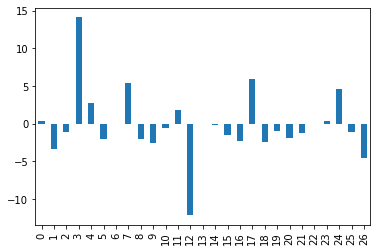

In [ ]:
#### Compare gains to Nifty 50 ####
nifty_raw = kite.historical_data(256265,extracted_data_df.time.iloc[-1],extracted_data_df.time.iloc[-1]+datetime.timedelta(days=60),'minute')
nifty_df = pd.DataFrame(nifty_raw)
nifty_gained_percent_in_60days =  100*(nifty_df.close.iloc[-1] - nifty_df.close[0])/nifty_df.close[0]
print(f'{nifty_gained_percent_in_60days=}')

this_telegram_channel_gained_percent_by_all_trades = extracted_data_df.gained_percent.sum()
print(f'{this_telegram_channel_gained_percent_by_all_trades=}')
outperforming_nifty_by_percentage =this_telegram_channel_gained_percent_by_all_trades- nifty_gained_percent_in_60days 
print(f'{outperforming_nifty_by_percentage=}')
total_number_of_trades_done = 2*len(extracted_data_df.index)
print(f'{total_number_of_trades_done=}')

### Calculate compunded gains ####
init_percent = 100.0
list_map = []
for one_percent in extracted_data_df.gained_percent.tolist()[::-1]:
    init_percent = init_percent*((100+one_percent)/100)
    list_map.append({'init_percent':init_percent,'one_percent':one_percent})
#     print(one_percent)
compounded_gains = init_percent-100
print(f'{compounded_gains=}')
## GAINED PERCENTAGE TRADE-WISE ###
extracted_data_df['gained_percent'].plot.bar()

In [ ]:
final_percent_gain_df = pd.DataFrame(nest, nest_symbol_list).T
final_percent_gain_df

,RAYMOND,GRANULES,TREJHARA,JMA,BLISSGVS,LIBERTSHOE,INDTERRAIN,CUBEXTUB,BALPHARMA,NIRAJ,...,ZODIACLOTH,INDOTECH,EMAMIREAL,JOCIL,CORDSCABLE,VERTOZ,SHANKARA,HUHTAMAKI,SHALPAINTS,JAIBALAJI
0,0.098039,0.111821,-0.422535,-0.972222,-0.304878,-0.255682,-0.447761,0.655738,-0.721649,-0.661157,...,-0.416667,-0.546448,-0.684932,-1.083744,-0.606061,-0.568182,0.000000,-0.666667,0.340909,-2.020202
1,0.098039,0.111821,0.000000,0.416667,-0.243902,-0.340909,-0.970149,2.459016,-0.051546,0.495868,...,0.000000,-0.546448,0.000000,0.369458,-0.530303,1.136364,-0.088945,-0.282051,1.420455,-2.020202
2,0.289216,0.287540,0.492958,0.833333,-0.365854,-0.454545,-0.820896,1.475410,0.051546,-0.165289,...,0.104167,-0.054645,0.000000,0.123153,-0.757576,1.250000,-0.114358,-0.230769,1.107955,-1.010101
3,0.289216,0.271565,0.845070,1.388889,-0.365854,1.136364,-0.597015,1.803279,-0.206186,-0.826446,...,0.312500,0.546448,0.000000,0.123153,-0.757576,1.250000,-0.133418,-0.128205,1.136364,-0.404040
4,0.289216,0.223642,1.056338,2.361111,-0.426829,0.937500,-0.597015,2.950820,0.618557,-0.826446,...,0.260417,2.185792,-2.054795,-0.615764,-0.606061,0.284091,-0.127065,0.410256,0.454545,-1.212121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166,NaN,NaN,NaN,1.736111,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6167,NaN,NaN,NaN,1.736111,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6168,NaN,NaN,NaN,1.805556,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6169,NaN,NaN,NaN,2.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
### add counter number at last in repeating column names
new_column_name_list = []
counter = 0
for one_name in final_percent_gain_df.keys().tolist():
    if(one_name not in new_column_name_list):
        new_column_name_list.append(one_name)
    else:
        new_column_name_list.append(one_name+'_'+str(counter))
        counter+=1
        
final_percent_gain_df.columns = new_column_name_list
final_percent_gain_df

,RAYMOND,GRANULES,TREJHARA,JMA,BLISSGVS,LIBERTSHOE,INDTERRAIN,CUBEXTUB,BALPHARMA,NIRAJ,...,ZODIACLOTH,INDOTECH,EMAMIREAL,JOCIL,CORDSCABLE,VERTOZ,SHANKARA,HUHTAMAKI,SHALPAINTS,JAIBALAJI
0,0.098039,0.111821,-0.422535,-0.972222,-0.304878,-0.255682,-0.447761,0.655738,-0.721649,-0.661157,...,-0.416667,-0.546448,-0.684932,-1.083744,-0.606061,-0.568182,0.000000,-0.666667,0.340909,-2.020202
1,0.098039,0.111821,0.000000,0.416667,-0.243902,-0.340909,-0.970149,2.459016,-0.051546,0.495868,...,0.000000,-0.546448,0.000000,0.369458,-0.530303,1.136364,-0.088945,-0.282051,1.420455,-2.020202
2,0.289216,0.287540,0.492958,0.833333,-0.365854,-0.454545,-0.820896,1.475410,0.051546,-0.165289,...,0.104167,-0.054645,0.000000,0.123153,-0.757576,1.250000,-0.114358,-0.230769,1.107955,-1.010101
3,0.289216,0.271565,0.845070,1.388889,-0.365854,1.136364,-0.597015,1.803279,-0.206186,-0.826446,...,0.312500,0.546448,0.000000,0.123153,-0.757576,1.250000,-0.133418,-0.128205,1.136364,-0.404040
4,0.289216,0.223642,1.056338,2.361111,-0.426829,0.937500,-0.597015,2.950820,0.618557,-0.826446,...,0.260417,2.185792,-2.054795,-0.615764,-0.606061,0.284091,-0.127065,0.410256,0.454545,-1.212121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166,NaN,NaN,NaN,1.736111,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6167,NaN,NaN,NaN,1.736111,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6168,NaN,NaN,NaN,1.805556,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6169,NaN,NaN,NaN,2.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

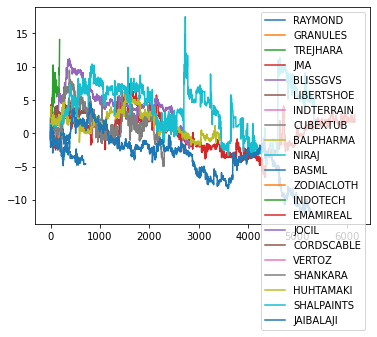

In [ ]:
final_percent_gain_df.plot()

# Listen to Telegram Channel for messages and predict tokens

In [ ]:
# Code from  https://python.plainenglish.io/telegram-channel-listener-with-python-8176ebe3c89b
import configparser
import json
import re
from telethon.errors import SessionPasswordNeededError
from telethon import TelegramClient, events, sync
from telethon.tl.functions.messages import (GetHistoryRequest)
from telethon.tl.types import (PeerChannel)

api_id = telegramAuth.api_id
api_hash = telegramAuth.api_hash
phone = telegramAuth.phone

user_input_channel = 'https://t.me/testchannelnottaken'

client = TelegramClient(phone, api_id, api_hash)

await client.connect()

if not await client.is_user_authorized():
    await client.send_code_request(phone)
    await client.sign_in(phone, input('Enter the code: '))
else :
    print('Autorised')

# Listen to messages from target channel 

@client.on(events.NewMessage()) 
async def newMessageListener(event):
    # Get message text 
    newMessage = event.message.message 
    classified_dict =  get_class_map_from_message_NEW(newMessage)
    print(classified_dict)
# #### GET FULL MESSAGE EVENT OBJECT in ASYNC MAnner #####
# @client.on(events.NewMessage)
# async def my_event_handler(event):
#     print('{}'.format(event))

In [ ]:
##### Start Listening to Messages ########
async with client: 
    print('Now wating for new messages...')
    await client.run_until_disconnected() 

# Supplimentry Functions

In [ ]:
### JOIN CHANNEL FROM TELEGRAM CLIENT (not from telepot BOT) ####
# from telethon.tl.functions.channels import JoinChannelRequest
# await client(JoinChannelRequest('https://t.me/INTRADAY_001'))

#### TELEGRAM BOT #####
# import telepot
# bot_tkn = telegramAuth.bot_tkn
# bt1 = telepot.Bot(bot_tkn)
# response = bt1.getUpdates()
# print(response)

# #### GET FULL MESSAGE EVENT OBJECT in ASYNC MAnner #####
# @client.on(events.NewMessage)
# async def my_event_handler(event):
#     print('{}'.format(event))
# await client.start()
# await client.run_until_disconnected()